# Abusing Detection (이준오)

## Modules

In [1]:
import pandas as pd
print("pandas version: ", pd.__version__)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)
import numpy as np
import sklearn

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

#classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

#tensorflow
import tensorflow as tf
from tensorflow.keras import layers

pandas version:  1.2.1


In [2]:
sns.__version__

'0.11.1'

# Read DataSet

In [3]:
testData = pd.read_csv('F:/2021 분석가 인턴과제/데이터분석가/type_D_골드파밍 어뷰저 분류 모델/abusingDetectionTestDataset.csv')
trainData = pd.read_csv('F:/2021 분석가 인턴과제/데이터분석가/type_D_골드파밍 어뷰저 분류 모델/abusingDetectionTrainDataset.csv')

In [4]:
import os
os.getcwd()

'F:\\2021 분석가 인턴과제\\데이터분석가\\type_D_골드파밍 어뷰저 분류 모델'

## 계획    
   
- Jamovi 프로그램을 사용하여 독립변수간 p-value값으로 얼마나 유의미한 관계인지 확인하여 독립변수를 선정한다.
- 1차적으로 선택한 변수들을 그래프로 시각화하여 데이터의 특성을 파악해본다.
- 기존의 ML알고리즘과 Keras를 이용한 DL을 둘다 사용하여 결과를 낸다.

## 1. EDA

---
컬럼 설명
- ```newID```: 캐릭터 식별자
- ```char_jobcode```: 직업 식별자
- ```char_level```: 캐릭터의 레벨
- ```logging_timestamp```: 해당 스냅샷 로그가 찍힌 시점
- ```charStatA ~ G```: 캐릭터의 성향정보로, 스냅샷 시점에 관계없이 계속 갱신됨 (예: 캐릭터의 매력도)
- ```socialAmount```: 타 캐릭터와의 인터랙션 정보로 그 양을 의미함 (예: 등록된 친구 수)
- ```socialBooleanA ~ B```: 타 캐릭터와의 인터랙션 정보로, 그 여부를 의미함(0 또는 1) (예: 길드 가입 여부)
- ```socialSessionAmountA ~ B```: 타 캐릭터와의 인터랙션 정보 중 스냅샷 세션 내 발생한 양을 의미함 (예: 세션 중 발생시킨 채팅 횟수)
- ```activityCumulativeAmountA ~ B```: 캐릭터의 액션 정보로서 생성시점부터 누적되는 값 (예: 누적 이벤트X 발생횟수)
- ```accountMetaAmountA```: 캐릭터가 속한 메타 정보로서 세션에 관계없이 갱신됨 (예: 캐릭터가 소속된 계정상의 정보)
- ```charSessionAmountA ~ C```: 캐릭터의 메타정보로서 세션동안 발생시킨 양 (예: 세션 중 특정맵A 방문 횟수)
- ```actionSessionAmountA ~ N```: 캐릭터가 세션 중 발생시킨 액션의 양 (예: 세션 중 사냥 횟수)
- ```tradeSessionAmountA ~ E```: 캐릭터가 세션 중 발생시킨 거래의 양 (예: 세션 중 개인간 거래 횟수)
- ```blocked```: 미래의 제재여부 (0: 비제재 / 1: 제재) (데이터셋상 제재시점은 주어지지 않았습니다)
---

In [5]:
# 데이터 요약 통계량 확인
trainData.describe(include='all')

,newID,char_jobcode,char_level,logging_timestamp,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,charStatG,socialAmountA,socialBooleanA,socialBooleanB,socialSessionAmountA,activityCumulativeAmountA,accountMetaAmountA,charSessionAmountA,charSessionAmountB,charMoveSessionAmountA,charSessionAmountC,socialSessionAmountB,actionSessionAmountA,charSessionAmountD,activityCumulativeAmountB,actionSessionAmountB,actionSessionAmountC,actionSessionAmountD,actionSessionAmountE,tradeSessionAmountA,tradeSessionAmountB,tradeSessionAmountC,actionSessionAmountF,actionSessionAmountG,actionSessionAmountH,actionSessionAmountI,actionSessionAmountJ,actionSessionAmountK,actionSessionAmountL,actionSessionAmountM,actionSessionAmountN,tradeSessionAmountD,tradeSessionAmountE,blocked
count,104399.000000,104399.000000,104399.000000,104399,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.0,104399.000000,104399.000000,104399.0,104399.000000,104399.0,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.00000,104399.000000,104399.000000,104399.0,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.000000,104399.0,104399.000000
unique,NaN,NaN,NaN,104387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,2017-6-19 0:35:58.153318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7484.512150,35.396651,48.324553,NaN,0.070815,39.750055,143.485100,0.631481,97.709269,16.134082,72.420119,1.664288,0.039541,0.0,0.071639,41.460550,0.0,1.295510,0.0,2.162846,0.004033,0.147166,1876.831598,7.442849,2.029560,343.358107,1.913380,0.182387,7.13025,0.084828,0.000307,0.0,2.304754,0.098602,0.026868,2.703762,0.199437,0.496624,700.909013,0.000766,1219.530082,0.054972,0.0,0.598282
std,4318.413739,21.345751,22.407708,NaN,1.017310,402.584594,1114.480669,11.328005,821.057198,264.802276,817.030460,8.858991,0.194878,0.0,0.292783,20.416135,0.0,2.686073,0.0,3.542159,0.111646,2.852550,1598.689375,2.055875,0.913094,366.704599,7.647901,1.025379,1.84907,0.585942,0.023568,0.0,5.236392,0.359934,0.162408,2.423407,0.880222,2.190545,962.844386,0.104952,1095.172136,0.448240,0.0,0.490248
min,0.000000,0.000000,10.000000,NaN,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,3763.000000,29.000000,31.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,34.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,441.000000,7.000000,1.000000,72.000000,0.000000,0.000000,6.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.000000,0.000000,222.000000,0.000000,0.0,0.000000
50%,7500.000000,30.000000,49.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,35.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,1575.000000,8.000000,2.000000,232.000000,0.000000,0.000000,6.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,202.000000,0.000000,1030.000000,0.000000,0.0,1.000000
75%,11254.000000,31.000000,61.000000,NaN,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,40.00

- accoutnMetaAmountA,charSessionAmountB,socialBooleanB,tradeSessionAmountC,tradeSessionAmountE 
<-- 모든값이 0 인것을 확인할 수 있다. 어뷰저를 판단하는데 의미가 없는 값이라고 판단함
- 컬럼 삭제

- 중복행 확인 후 제거

In [6]:
print("Old data" ,trainData.duplicated().value_counts())
trainData = trainData.drop_duplicates()
print("New data" ,trainData.duplicated().value_counts())

Old data False    104399
dtype: int64
New data False    104399
dtype: int64


In [7]:
trainData = trainData.drop(columns=['accountMetaAmountA','charSessionAmountB','socialBooleanB','tradeSessionAmountC','tradeSessionAmountE'])

In [8]:
trainData

,newID,char_jobcode,char_level,logging_timestamp,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,charStatG,socialAmountA,socialBooleanA,socialSessionAmountA,activityCumulativeAmountA,charSessionAmountA,charMoveSessionAmountA,charSessionAmountC,socialSessionAmountB,actionSessionAmountA,charSessionAmountD,activityCumulativeAmountB,actionSessionAmountB,actionSessionAmountC,actionSessionAmountD,actionSessionAmountE,tradeSessionAmountA,tradeSessionAmountB,actionSessionAmountF,actionSessionAmountG,actionSessionAmountH,actionSessionAmountI,actionSessionAmountJ,actionSessionAmountK,actionSessionAmountL,actionSessionAmountM,actionSessionAmountN,tradeSessionAmountD,blocked
0,0,0,10,2017-6-26 8:59:4.224398,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,44,7,0,7,0,0,6,0,0,0,0,0,0,0,0,2,0,0,0,0
1,0,0,31,2017-6-26 9:29:6.39562,0,0,0,0,2,0,0,0,0,0,49,0,0,0,0,510,7,0,57,0,0,6,0,0,1,0,0,0,0,2,146,0,106,0,0
2,0,0,40,2017-6-26 9:59:13.175257,0,0,0,0,2,0,0,0,0,0,62,0,0,0,0,469,6,0,140,0,0,9,0,0,2,0,0,0,0,2,229,0,172,0,0
3,0,0,61,2017-6-26 10:29:13.525274,0,0,0,0,6,0,0,0,0,0,65,0,0,0,0,1146,5,0,945,0,0,9,0,0,18,1,1,2,0,2,583,0,615,0,0
4,0,0,61,2017-6-27 7:51:56.193386,0,0,0,0,6,0,0,0,0,0,66,0,0,0,0,65,4,0,46,0,0,11,0,0,0,0,0,1,0,17,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104394,14915,120,47,2017-6-19 16:47:28.622771,1,0,4563,0,4575,0,1,0,0,0,90,0,1,0,0,872,4,2,76,0,0,10,0,0,3,1,0,4,0,0,89,0,59,0,0
104395,14915,132,16,2017-6-19 12:17:5.647646,0,0,4563,0,4563,0,0,0,0,0,19,0,0,0,0,115,6,1,15,0,0,7,0,0,0,0,0,0,0,0,45,0,44,0,0
104396,14915,132,23,2017-6-19 12:47:8.165005,0,0,4563,0,4565,0,0,0,0,0,25,0,0,0,0,490,6,1,43,0,0,8,0,0,0,0,0,0,0,0,195,0,153,0,0
104397,14915,132,27,2017-6-19 13:17:9.600144,0,0,4563,0,4565,0,0,0,0,0,32,0,0,0,0,476,6,1,26,0,0,8,0,0,0,0,0,1,0,0,193,0,152,0,0


In [9]:
# 데이터 type 확인
trainData.dtypes

newID                         int64
char_jobcode                  int64
char_level                    int64
logging_timestamp            object
charStatA                     int64
charStatB                     int64
charStatC                     int64
charStatD                     int64
charStatE                     int64
charStatF                     int64
charStatG                     int64
socialAmountA                 int64
socialBooleanA                int64
socialSessionAmountA          int64
activityCumulativeAmountA     int64
charSessionAmountA            int64
charMoveSessionAmountA        int64
charSessionAmountC            int64
socialSessionAmountB          int64
actionSessionAmountA          int64
charSessionAmountD            int64
activityCumulativeAmountB     int64
actionSessionAmountB          int64
actionSessionAmountC          int64
actionSessionAmountD          int64
actionSessionAmountE          int64
tradeSessionAmountA           int64
tradeSessionAmountB         

In [10]:
#결측치 확인
trainData.isnull().sum()

newID                        0
char_jobcode                 0
char_level                   0
logging_timestamp            0
charStatA                    0
charStatB                    0
charStatC                    0
charStatD                    0
charStatE                    0
charStatF                    0
charStatG                    0
socialAmountA                0
socialBooleanA               0
socialSessionAmountA         0
activityCumulativeAmountA    0
charSessionAmountA           0
charMoveSessionAmountA       0
charSessionAmountC           0
socialSessionAmountB         0
actionSessionAmountA         0
charSessionAmountD           0
activityCumulativeAmountB    0
actionSessionAmountB         0
actionSessionAmountC         0
actionSessionAmountD         0
actionSessionAmountE         0
tradeSessionAmountA          0
tradeSessionAmountB          0
actionSessionAmountF         0
actionSessionAmountG         0
actionSessionAmountH         0
actionSessionAmountI         0
actionSe

- 데이터들의 최소값에서 음수값을 발견하였으므로 정규화가 필요하다고 판단
- ```Data Scaling을 진행```

In [11]:
trainData.describe().min()

newID                         0.0
char_jobcode                  0.0
char_level                   10.0
charStatA                   -10.0
charStatB                     0.0
charStatC                     0.0
charStatD                     0.0
charStatE                     0.0
charStatF                     0.0
charStatG                     0.0
socialAmountA                 0.0
socialBooleanA                0.0
socialSessionAmountA          0.0
activityCumulativeAmountA     0.0
charSessionAmountA            0.0
charMoveSessionAmountA        0.0
charSessionAmountC            0.0
socialSessionAmountB          0.0
actionSessionAmountA          0.0
charSessionAmountD           -2.0
activityCumulativeAmountB     0.0
actionSessionAmountB          0.0
actionSessionAmountC          0.0
actionSessionAmountD          0.0
actionSessionAmountE          1.0
tradeSessionAmountA           0.0
tradeSessionAmountB           0.0
actionSessionAmountF          0.0
actionSessionAmountG          0.0
actionSessionA

## 2. 데이터 상관관계 확인

```Jamovi 사용```
#### Model Coefficients - blocked

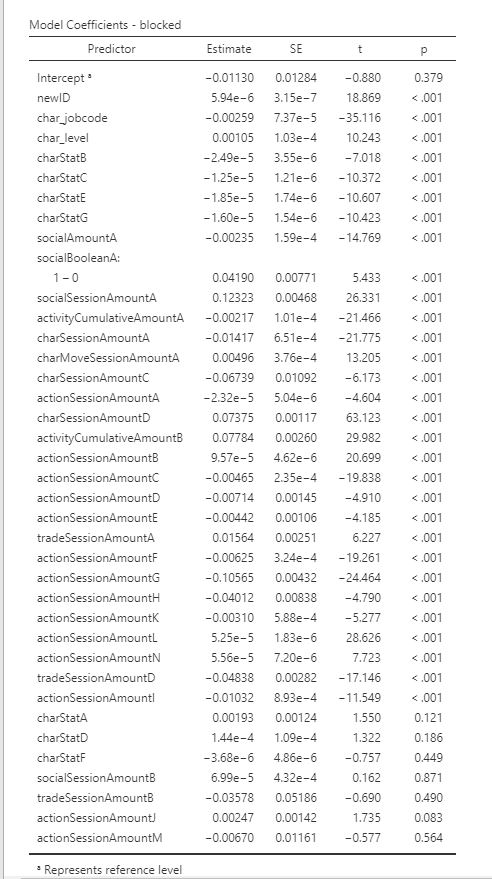

- 각 컬럼과 blocked가 유의미한지 참고하기위해 Jamovi프로그램을 사용하여 결과산출
- 머신러닝 모델링 전 참고용
- ```charStatA```, ```charStatB```, ```charStatF```, ```socialSessionAmountB```, ```tradeSessionAmountB```, ```actionSessionAmountJ```, ```actionSessionAmountM```의 p-value가 유의미한 0.01 보다 크므로 모델링에서 제외

- columns 수가 많으므로 일정 갯수의 columns 종속변수를 비교하여 상관관계를 그래프로 나타낸다.

In [12]:
trainData = trainData.drop(columns=['charStatA', 'charStatB', 'charStatF', 'socialSessionAmountB', 'tradeSessionAmountB', 'actionSessionAmountJ', 'actionSessionAmountM','logging_timestamp'])
trainData

,newID,char_jobcode,char_level,charStatC,charStatD,charStatE,charStatG,socialAmountA,socialBooleanA,socialSessionAmountA,activityCumulativeAmountA,charSessionAmountA,charMoveSessionAmountA,charSessionAmountC,actionSessionAmountA,charSessionAmountD,activityCumulativeAmountB,actionSessionAmountB,actionSessionAmountC,actionSessionAmountD,actionSessionAmountE,tradeSessionAmountA,actionSessionAmountF,actionSessionAmountG,actionSessionAmountH,actionSessionAmountI,actionSessionAmountK,actionSessionAmountL,actionSessionAmountN,tradeSessionAmountD,blocked
0,0,0,10,0,0,0,0,0,0,0,34,0,0,0,44,7,0,7,0,0,6,0,0,0,0,0,0,2,0,0,0
1,0,0,31,0,0,2,0,0,0,0,49,0,0,0,510,7,0,57,0,0,6,0,1,0,0,0,2,146,106,0,0
2,0,0,40,0,0,2,0,0,0,0,62,0,0,0,469,6,0,140,0,0,9,0,2,0,0,0,2,229,172,0,0
3,0,0,61,0,0,6,0,0,0,0,65,0,0,0,1146,5,0,945,0,0,9,0,18,1,1,2,2,583,615,0,0
4,0,0,61,0,0,6,0,0,0,0,66,0,0,0,65,4,0,46,0,0,11,0,0,0,0,1,17,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104394,14915,120,47,4563,0,4575,1,0,0,0,90,0,1,0,872,4,2,76,0,0,10,0,3,1,0,4,0,89,59,0,0
104395,14915,132,16,4563,0,4563,0,0,0,0,19,0,0,0,115,6,1,15,0,0,7,0,0,0,0,0,0,45,44,0,0
104396,14915,132,23,4563,0,4565,0,0,0,0,25,0,0,0,490,6,1,43,0,0,8,0,0,0,0,0,0,195,153,0,0
104397,14915,132,27,4563,0,4565,0,0,0,0,32,0,0,0,476,6,1,26,0,0,8,0,0,0,0,1,0,193,152,0,0


In [13]:
blocked = trainData.blocked

In [14]:
sectionA = pd.concat([trainData[trainData.columns[0:7]],blocked],axis=1)
sectionB = pd.concat([trainData[trainData.columns[7:14]],blocked],axis=1)
sectionC = pd.concat([trainData[trainData.columns[14:21]],blocked],axis=1)
sectionD = trainData[trainData.columns[21:]]

In [15]:
trainData

,newID,char_jobcode,char_level,charStatC,charStatD,charStatE,charStatG,socialAmountA,socialBooleanA,socialSessionAmountA,activityCumulativeAmountA,charSessionAmountA,charMoveSessionAmountA,charSessionAmountC,actionSessionAmountA,charSessionAmountD,activityCumulativeAmountB,actionSessionAmountB,actionSessionAmountC,actionSessionAmountD,actionSessionAmountE,tradeSessionAmountA,actionSessionAmountF,actionSessionAmountG,actionSessionAmountH,actionSessionAmountI,actionSessionAmountK,actionSessionAmountL,actionSessionAmountN,tradeSessionAmountD,blocked
0,0,0,10,0,0,0,0,0,0,0,34,0,0,0,44,7,0,7,0,0,6,0,0,0,0,0,0,2,0,0,0
1,0,0,31,0,0,2,0,0,0,0,49,0,0,0,510,7,0,57,0,0,6,0,1,0,0,0,2,146,106,0,0
2,0,0,40,0,0,2,0,0,0,0,62,0,0,0,469,6,0,140,0,0,9,0,2,0,0,0,2,229,172,0,0
3,0,0,61,0,0,6,0,0,0,0,65,0,0,0,1146,5,0,945,0,0,9,0,18,1,1,2,2,583,615,0,0
4,0,0,61,0,0,6,0,0,0,0,66,0,0,0,65,4,0,46,0,0,11,0,0,0,0,1,17,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104394,14915,120,47,4563,0,4575,1,0,0,0,90,0,1,0,872,4,2,76,0,0,10,0,3,1,0,4,0,89,59,0,0
104395,14915,132,16,4563,0,4563,0,0,0,0,19,0,0,0,115,6,1,15,0,0,7,0,0,0,0,0,0,45,44,0,0
104396,14915,132,23,4563,0,4565,0,0,0,0,25,0,0,0,490,6,1,43,0,0,8,0,0,0,0,0,0,195,153,0,0
104397,14915,132,27,4563,0,4565,0,0,0,0,32,0,0,0,476,6,1,26,0,0,8,0,0,0,0,1,0,193,152,0,0


In [16]:
len(trainData.columns)

31

## 3. Visualization

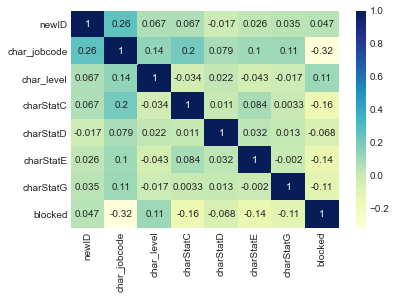

<Figure size 1080x648 with 0 Axes>

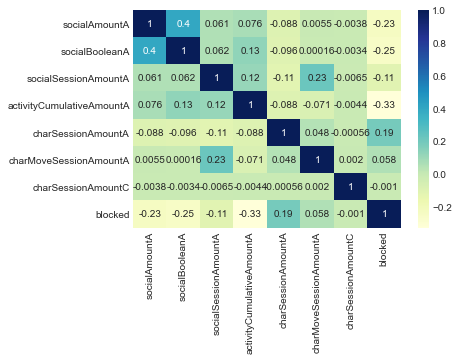

<Figure size 1080x648 with 0 Axes>

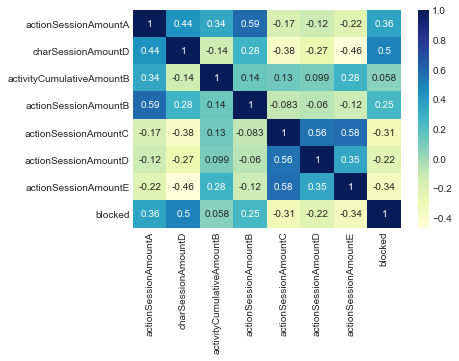

<Figure size 1080x648 with 0 Axes>

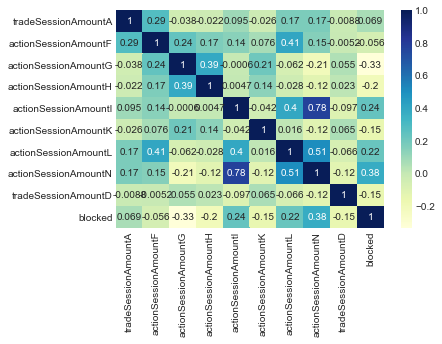

<Figure size 1080x648 with 0 Axes>

In [17]:
sns.heatmap(sectionA.corr(), annot =True, cmap="YlGnBu")
plt.figure(figsize =(15,9))
plt.show()
sns.heatmap(sectionB.corr(), annot =True, cmap="YlGnBu")
plt.figure(figsize =(15,9))
plt.show()
sns.heatmap(sectionC.corr(), annot =True, cmap="YlGnBu")
plt.figure(figsize =(15,9))
plt.show()
sns.heatmap(sectionD.corr(), annot =True, cmap="YlGnBu")
plt.figure(figsize =(15,9))
plt.show()

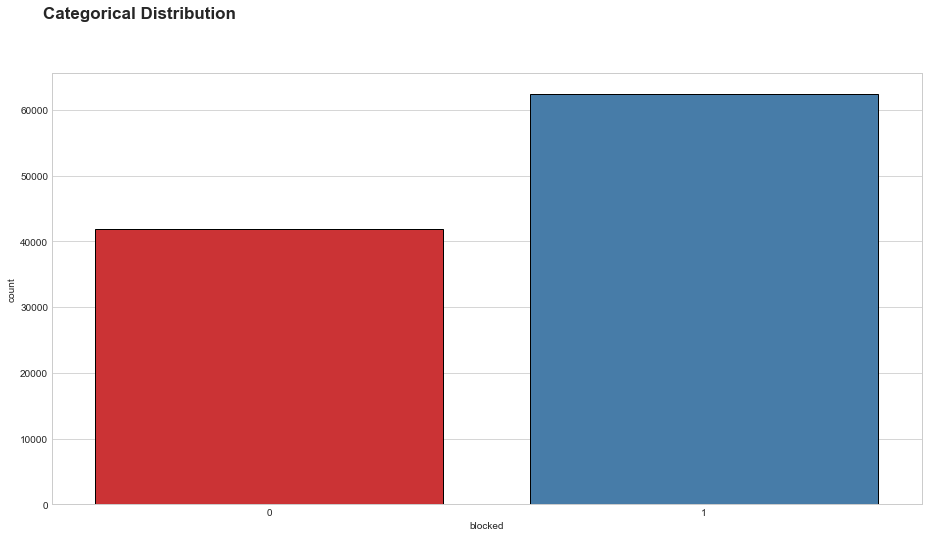

In [18]:
fig, axes =plt.subplots(1, 1, figsize=(13,7), sharey = True)

sns.countplot(x='blocked', data=trainData, ax=axes, palette="Set1", edgecolor='black')
   
# figure title    
plt.suptitle('Categorical Distribution', 
             fontsize=17, 
             fontweight='bold',
             x=0.05, y=1.06,
             ha='left' # horizontal alignment
            ) 

plt.tight_layout()
plt.show()

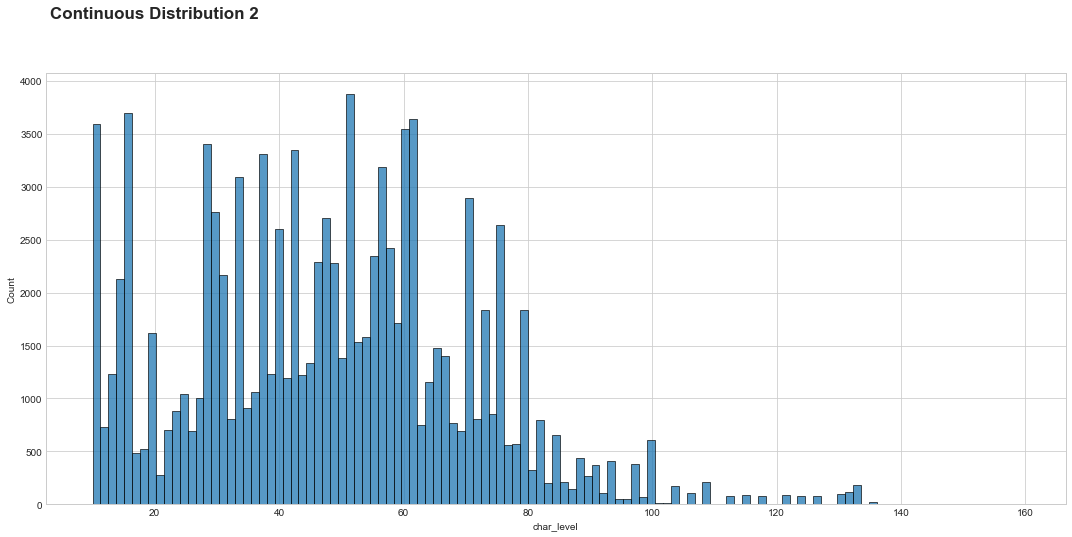

In [19]:
fig, axes =plt.subplots(1, 1, figsize=(15,7), sharey = True)
sns.histplot(x='char_level', data=trainData, ax=axes, palette="Set2", edgecolor='black')

# figure title    
plt.suptitle('Continuous Distribution 2', 
             fontsize=17, 
             fontweight='bold',
             x=0.05, y=1.06,
             ha='left' # horizontal alignment
            ) 

plt.tight_layout()
plt.show()

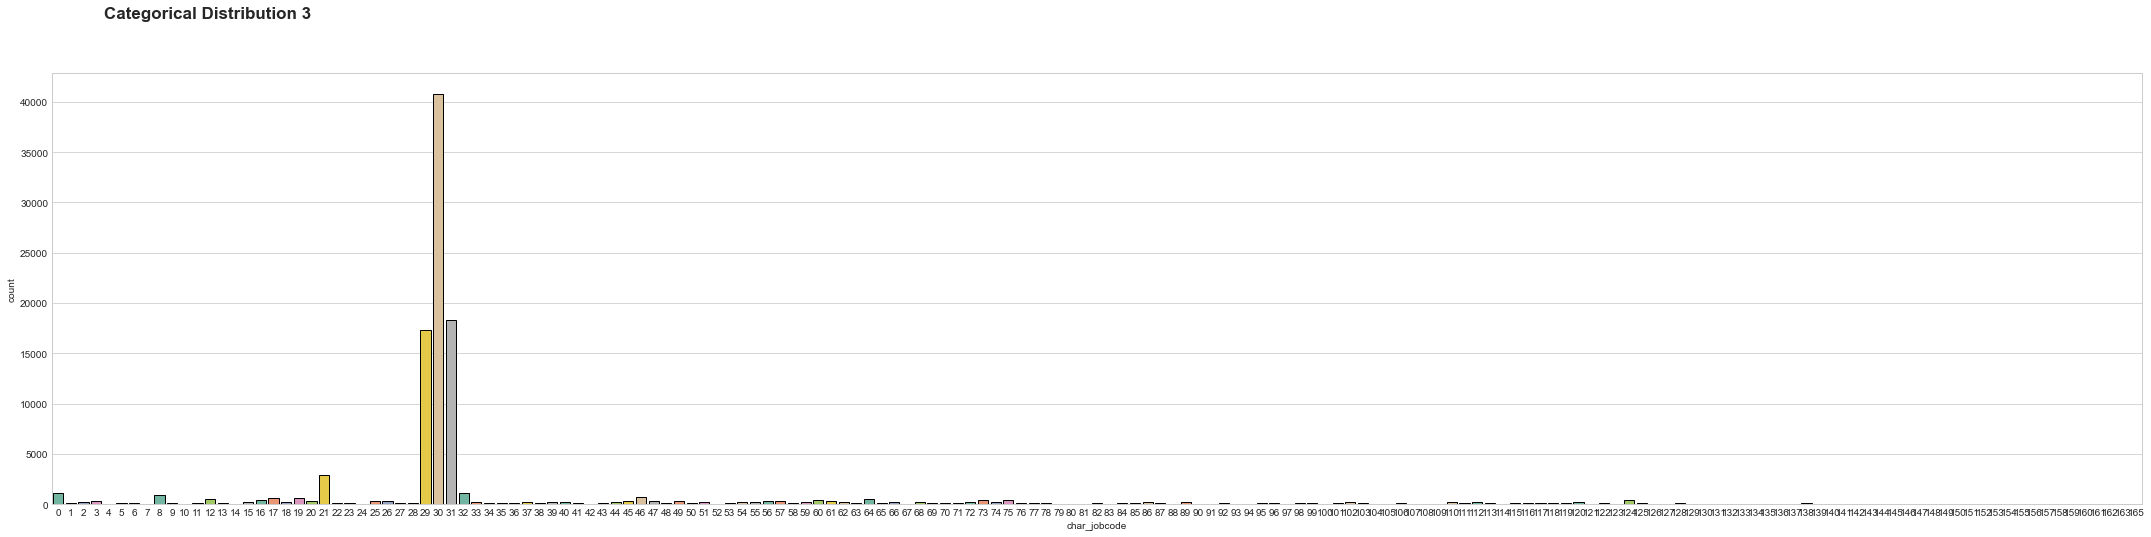

In [20]:
# 직업 식별자
fig, axes =plt.subplots(1, 1, figsize=(30,7), sharey = True)
sns.countplot(x='char_jobcode', data=trainData, ax=axes, palette="Set2", edgecolor='black')

# figure title    
plt.suptitle('Categorical Distribution 3', 
             fontsize=17, 
             fontweight='bold',
             x=0.05, y=1.06,
             ha='left' # horizontal alignment
            ) 

plt.tight_layout()
plt.show()

- jobcode는 29,30,31이 제일 많은 빈도를 보이고 있음

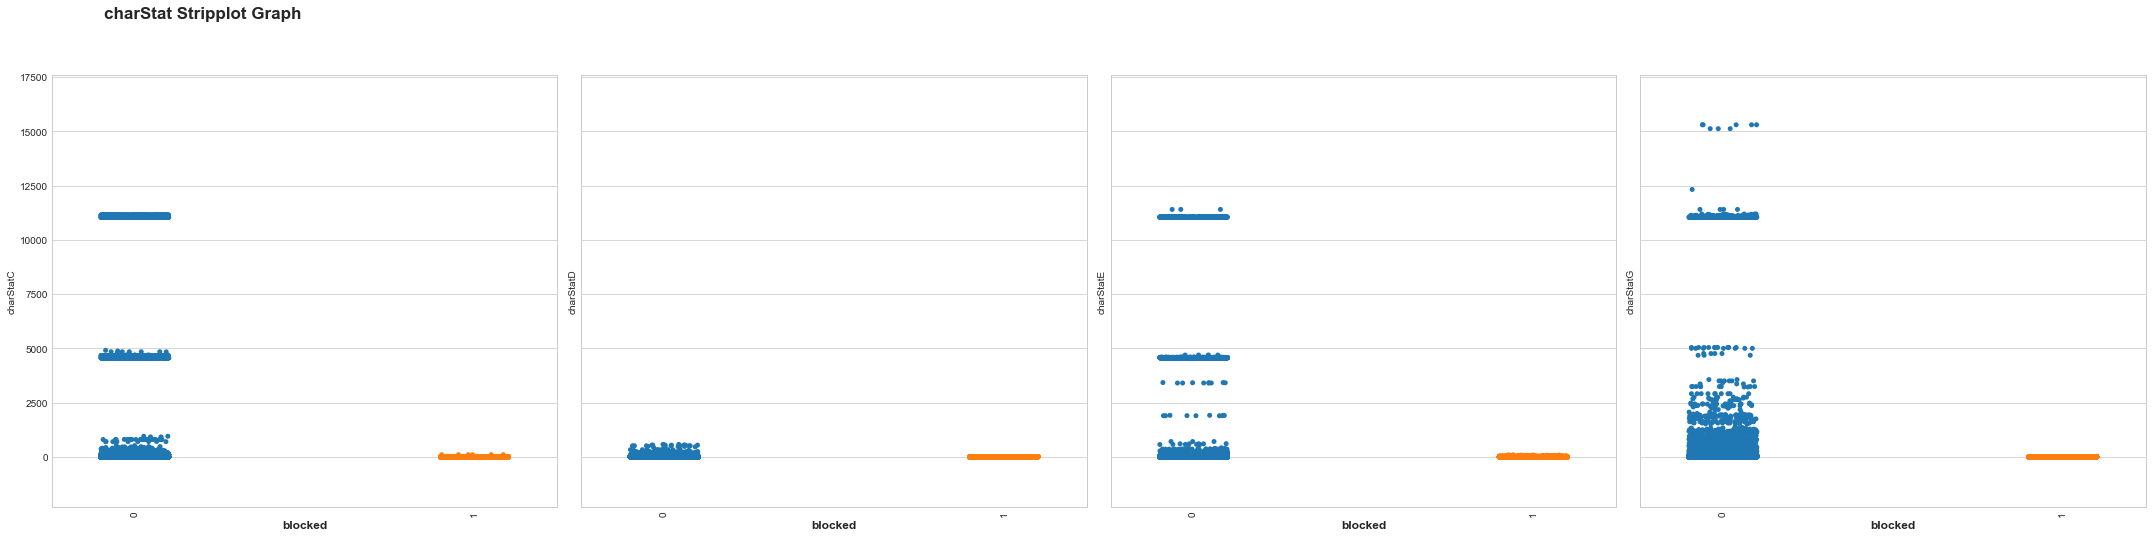

In [21]:
# 캐릭터의 성향정보
fig, axes =plt.subplots(1, 4, figsize=(30,7), sharey = True)

sns.stripplot(x='blocked', y='charStatC',data=trainData, ax=axes[0], edgecolor='black') 
sns.stripplot(x='blocked', y='charStatD',data=trainData, ax=axes[1], edgecolor='black') 
sns.stripplot(x='blocked', y='charStatE',data=trainData, ax=axes[2], edgecolor='black') 
sns.stripplot(x='blocked', y='charStatG',data=trainData, ax=axes[3], edgecolor='black') 

# figure title    
plt.suptitle('charStat Stripplot Graph', 
             fontsize=17, 
             fontweight='bold',
             x=0.05, y=1.06,
             ha='left' # horizontal alignment
            ) 

# Margin & Label 조정
for idx, ax in enumerate(axes) : 
    ax.margins(0.12, 0.15)
    ax.xaxis.label.set_size(12)
    ax.xaxis.label.set_weight('bold')
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=90 )    
    
plt.tight_layout()    
plt.show()

- 제제 당한 계정은 charStat이 0에 몰려있는 것을 확인할 수 있다.

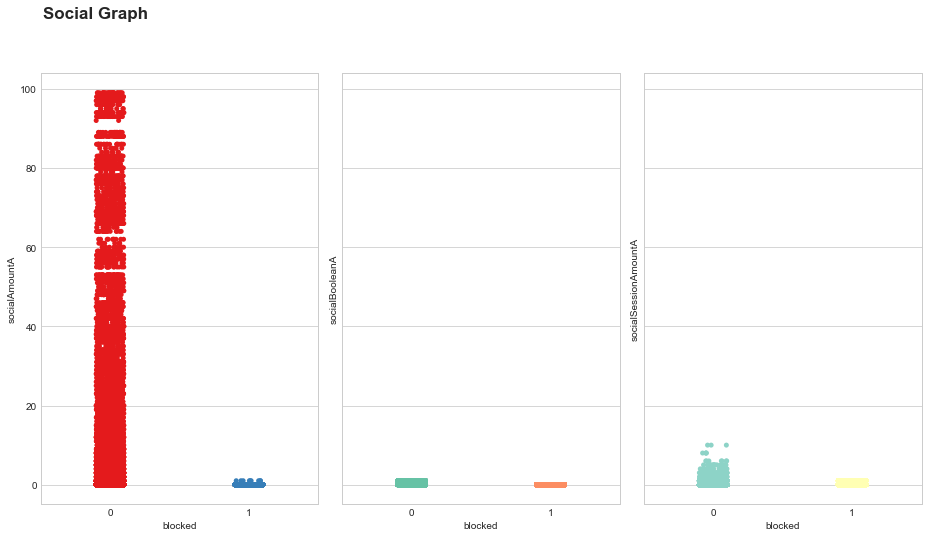

In [22]:
# 등록된 친구 수, 길드 가입 여부, 세션 중 발생 시킨 채팅 횟수 같은 소셜 데이터

fig, axes =plt.subplots(1, 3, figsize=(13,7), sharey = True)

sns.stripplot(x='blocked',y='socialAmountA', data=trainData, ax=axes[0], palette="Set1")
sns.stripplot(x='blocked',y='socialBooleanA', data=trainData, ax=axes[1], palette="Set2")
sns.stripplot(x='blocked',y='socialSessionAmountA', data=trainData, ax=axes[2], palette="Set3")

# figure title    
plt.suptitle('Social Graph', 
             fontsize=17, 
             fontweight='bold',
             x=0.05, y=1.06,
             ha='left' # horizontal alignment
            ) 

plt.tight_layout()
plt.show()

- socialAmount(예: 등록된 친구 수)는 제제당한 계정과 아닌 계정의 차이를 보이지만 
- socialBooleanA(예: 길드 가입 여부)는 큰 차이가 없는 것을 확인할 수 있다.
- socialSessionAmountA(예: 세션 중 발생 시킨 채팅 횟수) 제제당한 계정과 아닌계정에서 적은 차이를 보인다.


social 데이터를 확인하였을 때 제제당한 계정은 게임 내 social 활동이 적은 것으로 보여진다.


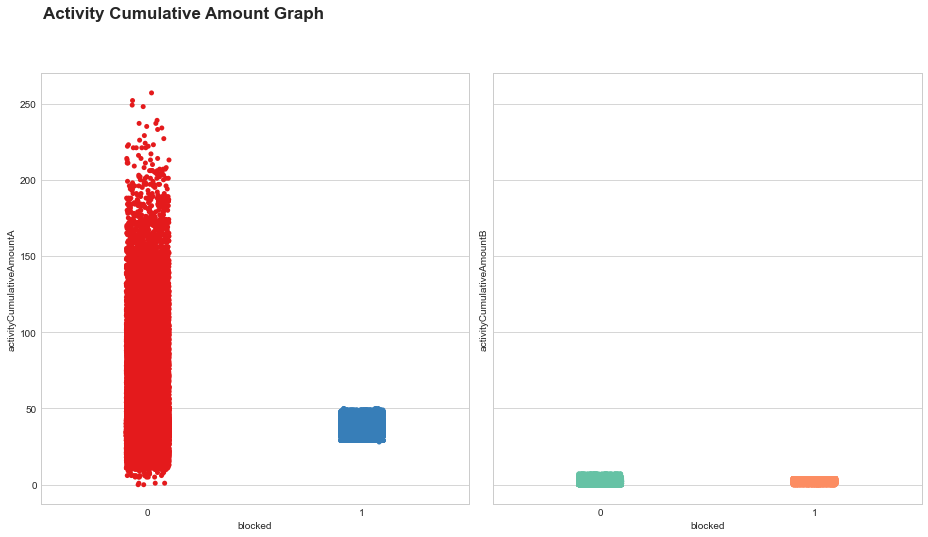

In [23]:
# 누적 이벤트X 발생횟수
# 캐릭터의 액션 정보로서 생성시점부터 누적되는 값

fig, axes =plt.subplots(1, 2, figsize=(13,7), sharey = True)

sns.stripplot(x='blocked',y='activityCumulativeAmountA', data=trainData, ax=axes[0], palette="Set1")
sns.stripplot(x='blocked',y='activityCumulativeAmountB', data=trainData, ax=axes[1], palette="Set2")

# figure title    
plt.suptitle('Activity Cumulative Amount Graph', 
             fontsize=17, 
             fontweight='bold',
             x=0.05, y=1.06,
             ha='left' # horizontal alignment
            ) 

plt.tight_layout()
plt.show()

- 누적이벤트 A의 그래프에서 특이한 점을 발견할 수 있는데 제제당한 계정에서 일정한 숫자로만 발생했다는 것을 확인할 수 있다.

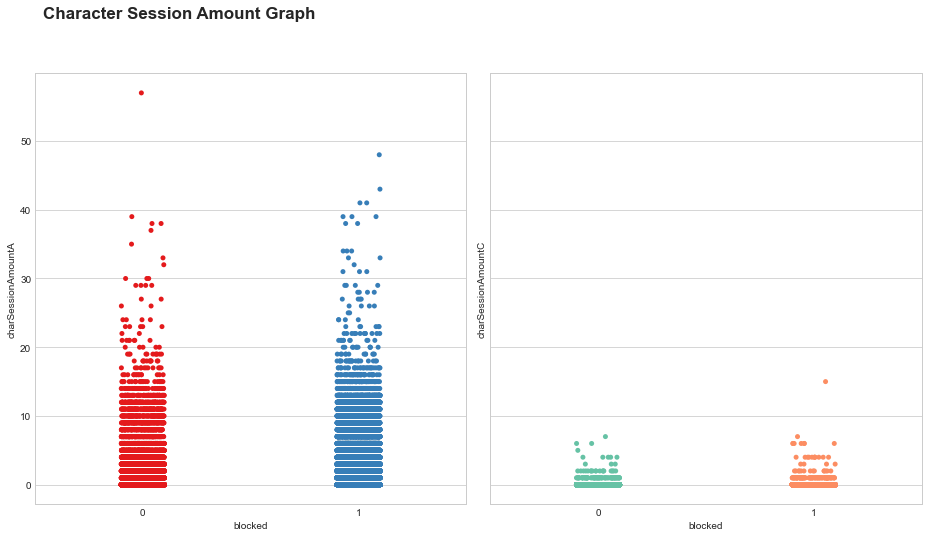

In [24]:
# 세션 중 특정맵 A,C 방문횟수

fig, axes =plt.subplots(1, 2, figsize=(13,7), sharey = True)

sns.stripplot(x='blocked',y='charSessionAmountA', data=trainData, ax=axes[0], palette="Set1")
sns.stripplot(x='blocked',y='charSessionAmountC', data=trainData, ax=axes[1], palette="Set2")

# figure title    
plt.suptitle('Character Session Amount Graph', 
             fontsize=17, 
             fontweight='bold',
             x=0.05, y=1.06,
             ha='left' # horizontal alignment
            ) 

plt.tight_layout()
plt.show()

- 골드파밍에 좋은 세션은 제제와 상관없이 고른 분포를 보여준다.

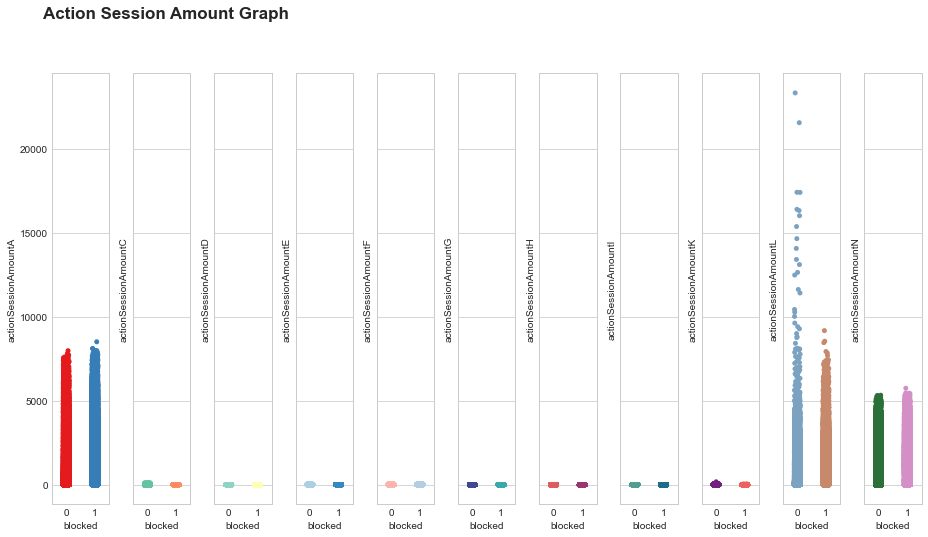

In [25]:
# 세션 중 사냥 횟수

fig, axes =plt.subplots(1, 11, figsize=(13,7), sharey = True)

sns.stripplot(x='blocked',y='actionSessionAmountA', data=trainData, ax=axes[0], palette="Set1")
sns.stripplot(x='blocked',y='actionSessionAmountC', data=trainData, ax=axes[1], palette="Set2")
sns.stripplot(x='blocked',y='actionSessionAmountD', data=trainData, ax=axes[2], palette="Set3")
sns.stripplot(x='blocked',y='actionSessionAmountE', data=trainData, ax=axes[3], palette="Blues")
sns.stripplot(x='blocked',y='actionSessionAmountF', data=trainData, ax=axes[4], palette="Pastel1")
sns.stripplot(x='blocked',y='actionSessionAmountG', data=trainData, ax=axes[5], palette="mako")
sns.stripplot(x='blocked',y='actionSessionAmountH', data=trainData, ax=axes[6], palette="flare")
sns.stripplot(x='blocked',y='actionSessionAmountI', data=trainData, ax=axes[7], palette="crest")
sns.stripplot(x='blocked',y='actionSessionAmountK', data=trainData, ax=axes[8], palette="magma")
sns.stripplot(x='blocked',y='actionSessionAmountL', data=trainData, ax=axes[9], palette="twilight_shifted")
sns.stripplot(x='blocked',y='actionSessionAmountN', data=trainData, ax=axes[10], palette="cubehelix")

# figure title    
plt.suptitle('Action Session Amount Graph', 
             fontsize=17, 
             fontweight='bold',
             x=0.05, y=1.06,
             ha='left' # horizontal alignment
            ) 

plt.tight_layout()
plt.show()

- 세션 중 어뷰저와 아닌캐릭터의 액션 수가 큰 차이를 보이지 않는 것을 확인 할 수 있다.

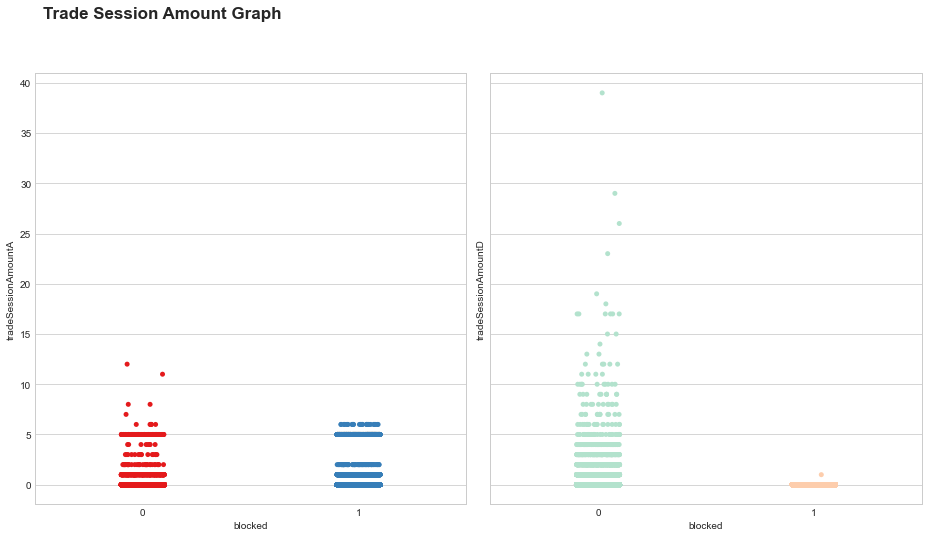

In [26]:
# 세션 중 개인간 거래 횟수

fig, axes =plt.subplots(1, 2, figsize=(13,7), sharey = True)

sns.stripplot(x='blocked',y='tradeSessionAmountA', data=trainData, ax=axes[0], palette="Set1")
sns.stripplot(x='blocked',y='tradeSessionAmountD', data=trainData, ax=axes[1], palette="Pastel2")

# figure title    
plt.suptitle('Trade Session Amount Graph', 
             fontsize=17, 
             fontweight='bold',
             x=0.05, y=1.06,
             ha='left' # horizontal alignment
            ) 

plt.tight_layout()
plt.show()

- 세션 중 개인간 거래가 필요한 것으로 보이는데 제제당한 계정에서 일정한 거래랑만 많이 보이는 패턴을 확인할 수 있다.
- 어뷰저의 특성이 나타난다고 설명할 수 있음

# ML/DL

## 1. VotingClassifier
 - DecisionTree
 - LogisticRegression
 - RandomForest

In [27]:
X,y = trainData.drop(columns=['blocked']),trainData['blocked']
X

,newID,char_jobcode,char_level,charStatC,charStatD,charStatE,charStatG,socialAmountA,socialBooleanA,socialSessionAmountA,activityCumulativeAmountA,charSessionAmountA,charMoveSessionAmountA,charSessionAmountC,actionSessionAmountA,charSessionAmountD,activityCumulativeAmountB,actionSessionAmountB,actionSessionAmountC,actionSessionAmountD,actionSessionAmountE,tradeSessionAmountA,actionSessionAmountF,actionSessionAmountG,actionSessionAmountH,actionSessionAmountI,actionSessionAmountK,actionSessionAmountL,actionSessionAmountN,tradeSessionAmountD
0,0,0,10,0,0,0,0,0,0,0,34,0,0,0,44,7,0,7,0,0,6,0,0,0,0,0,0,2,0,0
1,0,0,31,0,0,2,0,0,0,0,49,0,0,0,510,7,0,57,0,0,6,0,1,0,0,0,2,146,106,0
2,0,0,40,0,0,2,0,0,0,0,62,0,0,0,469,6,0,140,0,0,9,0,2,0,0,0,2,229,172,0
3,0,0,61,0,0,6,0,0,0,0,65,0,0,0,1146,5,0,945,0,0,9,0,18,1,1,2,2,583,615,0
4,0,0,61,0,0,6,0,0,0,0,66,0,0,0,65,4,0,46,0,0,11,0,0,0,0,1,17,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104394,14915,120,47,4563,0,4575,1,0,0,0,90,0,1,0,872,4,2,76,0,0,10,0,3,1,0,4,0,89,59,0
104395,14915,132,16,4563,0,4563,0,0,0,0,19,0,0,0,115,6,1,15,0,0,7,0,0,0,0,0,0,45,44,0
104396,14915,132,23,4563,0,4565,0,0,0,0,25,0,0,0,490,6,1,43,0,0,8,0,0,0,0,0,0,195,153,0
104397,14915,132,27,4563,0,4565,0,0,0,0,32,0,0,0,476,6,1,26,0,0,8,0,0,0,0,1,0,193,152,0


- TrainData scaling

In [28]:
#TrainData scaling
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()
X= standardScaler.fit_transform(X)

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split

In [31]:
clflog = LogisticRegression(random_state=1)
clfdt = DecisionTreeClassifier(random_state=1)
clfrf = RandomForestClassifier()

eclf_h=VotingClassifier(estimators = [('log',clflog),('dt',clfdt),('rf',clfrf),],voting='hard') # 다수결
eclf_s=VotingClassifier(estimators = [('log',clflog),('dt',clfdt),('rf',clfrf),],voting='soft') # 가중치

models = [clflog,clfdt,clfrf,eclf_h,eclf_s]

In [32]:
for model in models:
  model.fit(X_train,y_train)  
  predictions = model.predict(X_test)
  print(classification_report(y_test,predictions))

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.99      0.57      0.72     12457
           1       0.78      1.00      0.87     18863

    accuracy                           0.83     31320
   macro avg       0.88      0.78      0.80     31320
weighted avg       0.86      0.83      0.81     31320

              precision    recall  f1-score   support

           0       0.72      0.75      0.74     12457
           1       0.83      0.81      0.82     18863

    accuracy                           0.79     31320
   macro avg       0.78      0.78      0.78     31320
weighted avg       0.79      0.79      0.79     31320

              precision    recall  f1-score   support

           0       0.95      0.65      0.77     12457
           1       0.81      0.98      0.88     18863

    accuracy                           0.85     31320
   macro avg       0.88      0.81      0.83     31320
weighted avg       0.86      0.85      0.84     31320



D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.97      0.64      0.77     12457
           1       0.81      0.99      0.89     18863

    accuracy                           0.85     31320
   macro avg       0.89      0.81      0.83     31320
weighted avg       0.87      0.85      0.84     31320



D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.84      0.70      0.76     12457
           1       0.82      0.91      0.86     18863

    accuracy                           0.83     31320
   macro avg       0.83      0.81      0.81     31320
weighted avg       0.83      0.83      0.82     31320



- ```LogisticRegression```,```DecisionTreeClassifier```,```RandomForestClassifier```의 모델을 사용했을 때 ```RandomForestClassifier```가 accuracy와 f1-score가 높았다
- 분류기를 사용하여 3가지 모델을 합쳤을 때 voting 옵션이 Hard 일 때 제일 잘 맞추었다.

### 2. 모델에 testData로 결과산출

In [33]:
testData

,newID,char_jobcode,char_level,logging_timestamp,charStatA,charStatB,charStatC,charStatD,charStatE,charStatF,charStatG,socialAmountA,socialBooleanA,socialBooleanB,socialSessionAmountA,activityCumulativeAmountA,accountMetaAmountA,charSessionAmountA,charSessionAmountB,charMoveSessionAmountA,charSessionAmountC,socialSessionAmountB,actionSessionAmountA,charSessionAmountD,activityCumulativeAmountB,actionSessionAmountB,actionSessionAmountC,actionSessionAmountD,actionSessionAmountE,tradeSessionAmountA,tradeSessionAmountB,tradeSessionAmountC,actionSessionAmountF,actionSessionAmountG,actionSessionAmountH,actionSessionAmountI,actionSessionAmountJ,actionSessionAmountK,actionSessionAmountL,actionSessionAmountM,actionSessionAmountN,tradeSessionAmountD,tradeSessionAmountE
0,1,0,10,2017-6-25 1:44:56.567368,0,0,0,0,0,0,0,4,0,0,0,33,0,0,0,0,0,0,24,7,0,7,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,0,31,2017-6-25 2:14:59.563649,0,0,0,0,0,0,0,4,0,0,0,52,0,0,0,2,0,0,585,5,0,44,0,0,9,0,0,0,0,0,0,0,0,0,332,0,263,2,0
2,1,0,37,2017-6-25 2:45:5.783253,0,0,0,0,2,0,0,4,0,0,0,58,0,0,0,0,0,0,167,5,0,63,0,1,9,0,0,0,1,0,0,0,0,0,81,0,67,0,0
3,1,0,55,2017-6-25 3:15:13.798384,0,0,0,0,2,0,0,4,0,0,1,69,0,0,0,2,0,0,1211,5,0,200,0,1,9,0,0,0,11,2,1,1,0,0,676,0,706,0,0
4,1,0,73,2017-6-25 3:45:17.454384,0,0,0,0,6,0,0,4,0,0,1,71,0,0,0,2,0,0,1800,4,0,982,0,0,10,0,0,0,22,2,0,4,0,14,1454,0,1160,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,14907,121,106,2017-6-28 9:28:8.619503,0,0,4563,0,4565,0,0,0,1,0,1,29,0,0,0,5,0,0,1190,2,1,73,15,0,12,0,0,0,1,1,1,3,0,9,7,0,0,0,0
44732,14907,132,16,2017-6-24 6:9:47.218943,0,0,4563,0,4563,0,0,0,0,0,0,15,0,0,0,0,0,0,44,6,1,5,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44733,14907,132,16,2017-6-24 6:39:52.103677,0,0,4563,0,4565,0,0,0,0,0,0,15,0,0,0,0,0,0,0,6,1,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44734,14907,132,16,2017-6-24 7:9:59.873288,0,0,4563,0,4565,0,0,0,0,0,0,15,0,0,0,0,0,0,0,6,1,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- test 데이터 중복값 확인

In [34]:
testData.duplicated().value_counts()

False    44736
dtype: int64

In [35]:
newTestData = testData.drop(columns=['charStatA', 'charStatB', 'charStatF', 'socialSessionAmountB', 'tradeSessionAmountB', 'actionSessionAmountJ', 'actionSessionAmountM','logging_timestamp',\
                                    'accountMetaAmountA','charSessionAmountB','socialBooleanB','tradeSessionAmountC','tradeSessionAmountE'])
newTestData

,newID,char_jobcode,char_level,charStatC,charStatD,charStatE,charStatG,socialAmountA,socialBooleanA,socialSessionAmountA,activityCumulativeAmountA,charSessionAmountA,charMoveSessionAmountA,charSessionAmountC,actionSessionAmountA,charSessionAmountD,activityCumulativeAmountB,actionSessionAmountB,actionSessionAmountC,actionSessionAmountD,actionSessionAmountE,tradeSessionAmountA,actionSessionAmountF,actionSessionAmountG,actionSessionAmountH,actionSessionAmountI,actionSessionAmountK,actionSessionAmountL,actionSessionAmountN,tradeSessionAmountD
0,1,0,10,0,0,0,0,4,0,0,33,0,0,0,24,7,0,7,0,0,4,0,0,0,0,0,0,1,0,0
1,1,0,31,0,0,0,0,4,0,0,52,0,2,0,585,5,0,44,0,0,9,0,0,0,0,0,0,332,263,2
2,1,0,37,0,0,2,0,4,0,0,58,0,0,0,167,5,0,63,0,1,9,0,1,0,0,0,0,81,67,0
3,1,0,55,0,0,2,0,4,0,1,69,0,2,0,1211,5,0,200,0,1,9,0,11,2,1,1,0,676,706,0
4,1,0,73,0,0,6,0,4,0,1,71,0,2,0,1800,4,0,982,0,0,10,0,22,2,0,4,14,1454,1160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,14907,121,106,4563,0,4565,0,0,1,1,29,0,5,0,1190,2,1,73,15,0,12,0,1,1,1,3,9,7,0,0
44732,14907,132,16,4563,0,4563,0,0,0,0,15,0,0,0,44,6,1,5,0,0,6,0,0,0,0,0,0,0,0,0
44733,14907,132,16,4563,0,4565,0,0,0,0,15,0,0,0,0,6,1,0,0,0,6,0,0,0,0,0,0,0,0,0
44734,14907,132,16,4563,0,4565,0,0,0,0,15,0,0,0,0,6,1,0,0,0,6,0,0,0,0,0,0,0,0,0


In [36]:
newTestData.describe().min()

newID                         1.0
char_jobcode                  0.0
char_level                   10.0
charStatC                     0.0
charStatD                     0.0
charStatE                     0.0
charStatG                     0.0
socialAmountA                 0.0
socialBooleanA                0.0
socialSessionAmountA          0.0
activityCumulativeAmountA     0.0
charSessionAmountA            0.0
charMoveSessionAmountA        0.0
charSessionAmountC            0.0
actionSessionAmountA          0.0
charSessionAmountD           -2.0
activityCumulativeAmountB     0.0
actionSessionAmountB          0.0
actionSessionAmountC          0.0
actionSessionAmountD          0.0
actionSessionAmountE          1.0
tradeSessionAmountA           0.0
actionSessionAmountF          0.0
actionSessionAmountG          0.0
actionSessionAmountH          0.0
actionSessionAmountI          0.0
actionSessionAmountK          0.0
actionSessionAmountL          0.0
actionSessionAmountN          0.0
tradeSessionAm

## 3. ML Predict Result

In [37]:
#TestData scaling
newTestData = standardScaler.fit_transform(newTestData)

In [38]:
predictions = eclf_h.predict(newTestData)
MLpredResult=pd.DataFrame(data = predictions)
print(MLpredResult.value_counts())
MLpredResult

1    32525
0    12211
dtype: int64


,0
0,0
1,0
2,0
3,0
4,0
...,...
44731,0
44732,0
44733,0
44734,0


## 4. DL ( use tensorflow )

In [39]:
import tensorflow as tf
from tensorflow.keras import layers

In [40]:
tensorX = np.array(X)
tensorY = np.array(y)

In [41]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=0.0001)
sgd = optimizers.SGD(lr=0.001)

dense_kernel_regular = tf.keras.regularizers.l2(0.0001)

In [42]:
model= tf.keras.Sequential()
model.add(layers.Input(shape=[X.shape[1]]))
model.add(layers.Dense(4, activation='relu',kernel_regularizer=dense_kernel_regular)) # reqularizer
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(1, activation='sigmoid'))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3,restore_best_weights=True) # 얼리스탑
model.compile(loss='mean_squared_error', optimizer=adam ,metrics=['accuracy','binary_accuracy'])

history = model.fit(X,tensorY,epochs=300, batch_size=512, verbose=1,validation_split=0.2 ,callbacks=[callback])

Epoch 1/300
164/164 [==============================] - 0s 3ms/step - loss: 0.2441 - accuracy: 0.6590 - binary_accuracy: 0.6590 - val_loss: 0.2391 - val_accuracy: 0.5784 - val_binary_accuracy: 0.5784
Epoch 2/300
164/164 [==============================] - 0s 2ms/step - loss: 0.2136 - accuracy: 0.7474 - binary_accuracy: 0.7474 - val_loss: 0.1749 - val_accuracy: 0.7888 - val_binary_accuracy: 0.7888
Epoch 3/300
164/164 [==============================] - 0s 2ms/step - loss: 0.1802 - accuracy: 0.7728 - binary_accuracy: 0.7728 - val_loss: 0.1450 - val_accuracy: 0.8073 - val_binary_accuracy: 0.8073
Epoch 4/300
164/164 [==============================] - 0s 2ms/step - loss: 0.1666 - accuracy: 0.7842 - binary_accuracy: 0.7842 - val_loss: 0.1353 - val_accuracy: 0.8119 - val_binary_accuracy: 0.8119
Epoch 5/300
164/164 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.7910 - binary_accuracy: 0.7910 - val_loss: 0.1320 - val_accuracy: 0.8130 - val_binary_accuracy: 0.8130
Epoch

164/164 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.8197 - binary_accuracy: 0.8197 - val_loss: 0.1193 - val_accuracy: 0.8236 - val_binary_accuracy: 0.8236
Epoch 43/300
164/164 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.8197 - binary_accuracy: 0.8197 - val_loss: 0.1201 - val_accuracy: 0.8222 - val_binary_accuracy: 0.8222
Epoch 44/300
164/164 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.8199 - binary_accuracy: 0.8199 - val_loss: 0.1185 - val_accuracy: 0.8242 - val_binary_accuracy: 0.8242
Epoch 45/300
164/164 [==============================] - 0s 2ms/step - loss: 0.1396 - accuracy: 0.8199 - binary_accuracy: 0.8199 - val_loss: 0.1189 - val_accuracy: 0.8235 - val_binary_accuracy: 0.8235
Epoch 46/300
164/164 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.8199 - binary_accuracy: 0.8199 - val_loss: 0.1182 - val_accuracy: 0.8245 - val_binary_accuracy: 0.8245
Epoch 47/300


164/164 [==============================] - 0s 2ms/step - loss: 0.1379 - accuracy: 0.8215 - binary_accuracy: 0.8215 - val_loss: 0.1161 - val_accuracy: 0.8295 - val_binary_accuracy: 0.8295
Epoch 84/300
164/164 [==============================] - 0s 3ms/step - loss: 0.1378 - accuracy: 0.8215 - binary_accuracy: 0.8215 - val_loss: 0.1143 - val_accuracy: 0.8342 - val_binary_accuracy: 0.8342
Epoch 85/300
164/164 [==============================] - 0s 2ms/step - loss: 0.1378 - accuracy: 0.8216 - binary_accuracy: 0.8216 - val_loss: 0.1153 - val_accuracy: 0.8321 - val_binary_accuracy: 0.8321
Epoch 86/300
164/164 [==============================] - 0s 2ms/step - loss: 0.1379 - accuracy: 0.8216 - binary_accuracy: 0.8216 - val_loss: 0.1156 - val_accuracy: 0.8312 - val_binary_accuracy: 0.8312
Epoch 87/300
164/164 [==============================] - 0s 2ms/step - loss: 0.1378 - accuracy: 0.8216 - binary_accuracy: 0.8216 - val_loss: 0.1143 - val_accuracy: 0.8344 - val_binary_accuracy: 0.8344
Epoch 88/300


In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'binary_accuracy', 'val_loss', 'val_accuracy', 'val_binary_accuracy'])

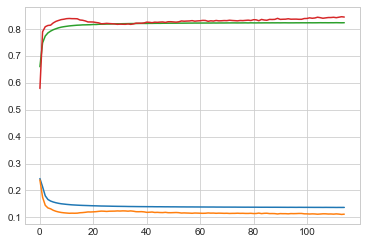

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [45]:
model.evaluate(X,y,batch_size=64) # 내부데이터 check

1632/1632 [==============================] - 1s 683us/step - loss: 0.1322 - accuracy: 0.8258 - binary_accuracy: 0.8258


[0.13216611742973328, 0.8257741928100586, 0.8257741928100586]

In [46]:
model.summary() # 모델 내부 구조

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 124       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6

## 5. DL Predict Result

In [47]:
#TestData scaling
newTestDataDL = standardScaler.fit_transform(newTestData)

In [48]:
pred = model.predict(newTestDataDL)

- Threshold로 결과값을 낸다

In [49]:
#Threshold
result=np.where(pred>0.5,1,0)
print(len(result))

44736


In [50]:
DLpredResult= pd.DataFrame(result)
DLpredResult.value_counts()

1    35070
0     9666
dtype: int64

# Final Result

- DL과 ML에서 가장 좋은 Accuracy(정확도)를 보인 모델은 VotingClassifier에서 hard 속성을 가진 것으로 최종 모델로 제출합니다

In [51]:
finalResult = pd.concat([testData['newID'],MLpredResult],axis=1)

In [52]:
finalResult.columns = ['newID','res']
finalResult

,newID,res
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
44731,14907,0
44732,14907,0
44733,14907,0
44734,14907,0


In [53]:
finalResult.to_excel('final_Result_이준오.xlsx', index=False)